# Gerador de Imagens com GANs (DCGAN) - PyTorch

Neste notebook, vamos criar uma Rede Generativa Adversarial (GAN) para gerar imagens sintéticas com base no dataset MNIST. Usaremos a arquitetura DCGAN (Deep Convolutional GAN), que aplica convoluções profundas ao Gerador e ao Discriminador. A ideia principal é que duas redes (Gerador e Discriminador) competem entre si até que o Gerador consiga enganar o Discriminador com imagens "falsas" mas realistas.

## Objetivos:
- Compreender a estrutura de uma GAN
- Implementar um Gerador e Discriminador convolucionais
- Treinar o modelo para gerar imagens a partir de vetores aleatórios



### Importação de bibliotecas

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import os


### Carregando e Pré-processando o CIFAR-10

- Redimensionar imagens para 64x64 (como esperado pela DCGAN).

- Normalizar pixels para a faixa [-1, 1] (funciona melhor com tanh no gerador).

- Carregar dados com DataLoader para batches.

In [2]:
# Hiperparâmetros básicos
batch_size = 128
image_size = 64  # CIFAR-10 vem com 32x32, vamos redimensionar para 64x64
workers = 2
dataroot = "./data"

# Transformações de imagem
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # Normaliza para [-1, 1]
])

# Dataset e DataLoader
dataset = dsets.CIFAR10(root=dataroot, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

# Dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170M/170M [00:52<00:00, 3.22MB/s]


Usando dispositivo: cpu


### Verificação: visualizar imagens reais

Mostrar algumas imagens reais para verificar

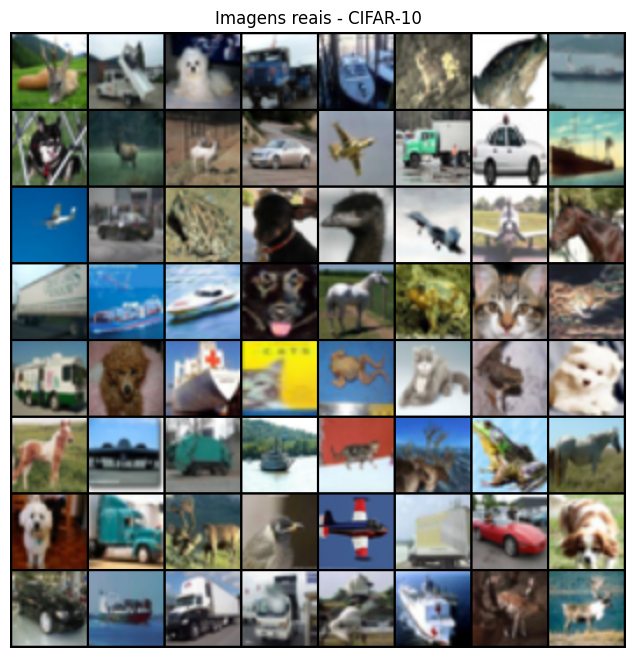

In [3]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Imagens reais - CIFAR-10")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()

### Definindo o Gerador e o Discriminador (DCGAN)

**Arquitetura usada:** 
- Gerador: transforma vetores aleatórios (ruído) em imagens 64x64x3.

- Discriminador: classifica se uma imagem 64x64x3 é real ou falsa.

#### Hiperparâmetros para as redes

In [4]:
nz = 100        # Tamanho do vetor de entrada (ruído)
ngf = 64        # Filtros no gerador (base)
ndf = 64        # Filtros no discriminador (base)
nc = 3          # Canais da imagem (RGB)

### 🎨 Gerador

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input: Z (batch_size x 100 x 1 x 1)
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            # (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            # (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            # (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            # (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()  # Saída entre [-1, 1]
        )

    def forward(self, input):
        return self.main(input)


### 🕵️‍♂️ Discriminador

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input: (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()  # Probabilidade entre 0 e 1
        )

    def forward(self, input):
        return self.main(input).view(-1)


### Instanciando os modelos

In [7]:
netG = Generator().to(device)
netD = Discriminator().to(device)

# Inicializar pesos (DCGAN recomenda normal média 0, desvio 0.02)
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

netG.apply(weights_init)
netD.apply(weights_init)

print("Gerador:")
print(netG)
print("\nDiscriminador:")
print(netD)


Gerador:
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh

### Função de Perda e Otimizadores

**O que estamos fazendo:**
- Usamos Binary Cross Entropy (BCE) como função de perda.

- Definimos otimizadores Adam para ambas as redes.

- Ajustamos os hiperparâmetros recomendados para GANs: betas = (0.5, 0.999).

### ✅ Função de perda

In [8]:
criterion = nn.BCELoss()

### 🏷️ Labels fixos para treino

In [9]:
real_label = 1.
fake_label = 0.


### 🧠 Vetor de entrada (ruído)

In [10]:
fixed_noise = torch.randn(64, nz, 1, 1, device=device)  # usado para gerar imagens fixas durante o treino

### 🧪 Otimizadores

In [11]:
lr = 0.0002

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))


### Loop de Treino

- Treinamos o Discriminador com imagens reais e falsas.

- Treinamos o Gerador para tentar "enganar" o Discriminador.

- Salvamos métricas, imagens e (opcionalmente) os modelos.


In [ ]:
import time

num_epochs = 25
img_list = []
G_losses = []
D_losses = []

print("Iniciando o treino...")
start_time = time.time()

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Atualiza o Discriminador
        ############################
        netD.zero_grad()
        real_images = data[0].to(device)
        b_size = real_images.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        # Forward real
        output = netD(real_images)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # Imagens falsas geradas
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_images = netG(noise)
        label.fill_(fake_label)

        # Forward falso
        output = netD(fake_images.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        # Soma perdas e otimiza D
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Atualiza o Gerador
        ############################
        netG.zero_grad()
        label.fill_(real_label)  # Tenta enganar o D
        output = netD(fake_images)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Salva perdas
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Exibir progresso
        if i % 50 == 0:
            print(f"[{epoch}/{num_epochs}][{i}/{len(dataloader)}] "
                  f"Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} "
                  f"D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}")

    # Salva imagens geradas a cada epoch
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

print(f"Treino finalizado em {(time.time() - start_time)/60:.2f} minutos.")


Iniciando o treino...
[0/25][0/391] Loss_D: 1.9528 Loss_G: 6.7671 D(x): 0.6095 D(G(z)): 0.6804/0.0019
